In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

##Code for analysis of fMRI experiment

In [2]:
%matplotlib inline

In [3]:
##function for reading out data from log file
def line_to_matrix(line):
	line = line.split('=')[1]
	line = line.split(',')
	line = map(float,line)
	line = np.array(line)
	new_out = line.reshape(-1,5)
	return new_out

In [4]:
##takes the mturk results file and makes a dictionary mapping
##the worker id to the assignment id
def get_assignment_id(assignment_file):
	rowNum=0
	worker_id_2_assignment_id = {}
	with(open(assignment_file,'rU')) as f:
		reader = csv.reader(f)
		#worker id is 15 and 14
		for row in reader:
	 		if rowNum > 0:
				worker_id_2_assignment_id[row[15]] = row[14]
			rowNum += 1
	return worker_id_2_assignment_id

In [5]:
##processed RT arrays. They are coded with a negative number for pre-target responses and -1
##missed responses. This replaces -1 with NaN, changes negative to positive, and offsets positive
##RTs by the delay to the target
def clean_RT(data,delay,thresh):
#     print "uncleaned"
#     print data
    count = 0
    if np.ndim(data) > 0: #array
        data[data==-1] = np.nan
        data[data>0] = data[data>0] + delay
        data[data<0] = data[data<0] *-1
    else: #float
        if data == -1:
            data = np.nan
        elif data>0:
            data = data + delay
        elif data < 0:
            data = data *-1
            count += 1
#     print "cleaned"
#     print data
#     print '\n'
    data = data - thresh #normalize by that subject's RT in training
    return data, count

In [6]:
##variables and paths
data_dir = '/Users/ianballard/Dropbox/fd/'
delay_dur = 600 ##delay before target appears

In [7]:
def process_log_files(log_files):
    full_data = {}
    for n,f in enumerate(log_files):
        
        #read file
        subj_file = open(os.path.join(data_dir,f),'r')
        subj_file = subj_file.readlines()
        subj_file = np.array(subj_file)
        
        ##process file into dictionary of dictionaries
        subj_dict = {}
        for n,line in enumerate(subj_file):
            subject_line = line.split(' ')[1].split('=')[0].split('%20') #0th index is subid, 1st is that lines id
            if len(subject_line) == 2:
                try: 
                    full_data[subject_line[0]][subject_line[1]] = line.split(' ')[1].split('=')[1].strip('\n')
                except:
                    full_data[subject_line[0]] = {} ##make dictionary
                    full_data[subject_line[0]][subject_line[1]] = line.split(' ')[1].split('=')[1].strip('\n')
      
        #clean up false alarm, bonus, and description data
#         for key in full_data:
#             full_data[key]['fa_ser'] = full_data[key]['fa_ser'].split(',')[:-1]
#             full_data[key]['fa_sim'] = full_data[key]['fa_sim'].split(',')[:-1]
#             full_data[key]['instruct_ser'] = full_data[key]['instruct_ser'].replace('%20', ' ')
#             full_data[key]['instruct_sim'] = full_data[key]['instruct_sim'].replace('%20', ' ')
#             full_data[key]['bonus_ser'] = float(full_data[key]['bonus_ser'])
#             full_data[key]['bonus_sim'] = float(full_data[key]['bonus_sim'])

    return full_data

In [8]:
#preprocesses data. Takes subj_dict, string indicating which key to analyze, and dimensions to reshaping
def preprocess_data(subj_dict,key,num_entries):
    x = map(float,subj_dict[key].split(','))
    x = np.array(x)
    x = x.reshape((x.size/num_entries, num_entries))
    return x


In [9]:
##analyze reaction time data for rt thresholding task
def process_rt(full_data,subj_list, print_file_flag):
    accuracy = np.array([])
    rt_thresh = {}
    for f in full_data:
        if f in subj_list:
            if print_file_flag:
                print f
            rt = preprocess_data(full_data[f], 'rt', 3)
            rt = np.array([y for y in rt if y[0]!=-2. and y[1] < 4000 and y[0] != -1.]) #remove trials without button press, bug trials, trials with missed answers
            rt_thresh[f] = rt[-1,2] #last rt threshold of training
            ##get stats
            accuracy = np.hstack([accuracy, 1 - np.array([x for x in rt if x[0]==0.]).shape[0]/float(rt.shape[0])])
            rt = np.mean(rt, axis = 0)[1]
    
    print np.mean(accuracy[accuracy>.2])
    print accuracy
    return accuracy, rt_thresh

In [10]:
def analyze_rt_task(rt,rt_switch, accuracy_dict,rt_thresh, ser, rew, order,trials):
    num_f_trials = 7
    num_switch_trials = 3

    ##collect data
    fp_plus = np.where(order == trials[0])[-1] ##ser fp +
    fp_plus = [a for n,a in enumerate(fp_plus) if rew[fp_plus][n] == 1] 
    fp_plus_rt, count = clean_RT(ser[fp_plus,1],delay_dur,rt_thresh)
    accuracy_dict['fp_accuracy'] = np.hstack([accuracy_dict['fp_accuracy'],
                                             np.sum(ser[fp_plus,0] == .25)*1.0 / num_f_trials])

    fn_plus = np.where(order == trials[1])[-1] ##ser fn +
    fn_plus = [a for n,a in enumerate(fn_plus) if rew[fn_plus][n] == 1] 
    fn_plus_rt, count = clean_RT(ser[fn_plus,1],delay_dur,rt_thresh)
    accuracy_dict['fn_accuracy'] = np.hstack([accuracy_dict['fn_accuracy'],
                                             np.sum(ser[fn_plus,0] == .25)*1.0 / num_f_trials])

    fp_switch = np.where(order == trials[2])[-1] ##ser fp +
    fp_switch = [a for n,a in enumerate(fp_switch) if rew[fp_switch][n] == 1] 
    fp_switch_rt, count = clean_RT(ser[fp_switch,1],delay_dur,rt_thresh)
    accuracy_dict['fp_switch_accuracy'] = np.hstack([accuracy_dict['fp_switch_accuracy'],
                                             np.sum(ser[fp_switch,0] == .25)*1.0 / num_switch_trials])    
    
    fn_switch = np.where(order == trials[3])[-1] ##ser fn +
    fn_switch = [a for n,a in enumerate(fn_switch) if rew[fn_switch][n] == 1] 
    fn_switch_rt, count = clean_RT(ser[fn_switch,1],delay_dur,rt_thresh)
    accuracy_dict['fn_switch_accuracy'] = np.hstack([accuracy_dict['fn_switch_accuracy'],
                                             np.sum(ser[fn_switch,0] == .25)*1.0 / num_switch_trials]) 

    rt.append(pd.DataFrame(dict(condition=["fn"] * num_f_trials,
                                    subj = [f] * num_f_trials,
                                    presentation = np.arange(0,num_f_trials),
                                    RT = fn_plus_rt), dtype=np.float))
    rt.append(pd.DataFrame(dict(condition=["fp"] * num_f_trials,
                            subj = [f] * num_f_trials,
                            presentation = np.arange(0,num_f_trials),
                            RT = fp_plus_rt), dtype=np.float))    
    rt_switch.append(pd.DataFrame(dict(condition=["fn"] * num_switch_trials,
                                    subj = [f] * num_switch_trials,
                                    presentation = np.arange(0,num_switch_trials),
                                    RT = fn_switch_rt), dtype=np.float))
    rt_switch.append(pd.DataFrame(dict(condition=["fp"] * num_switch_trials,
                            subj = [f] * num_switch_trials,
                            presentation = np.arange(0,num_switch_trials),
                            RT = fp_switch_rt), dtype=np.float))    
    return rt,rt_switch,accuracy_dict


In [11]:
##MAIN ANALYSIS CODE
##make subject lists
subj_list = []
subj_list_practice = []
bad_subs = [103,107,108,109,111,116,121,125]
for i in range(101,131):
    if i not in bad_subs and i!=129: #no practice for 129
        subj_list.append(str(i)+'_1')
        subj_list.append(str(i)+'_2')
        subj_list.append(str(i)+'_3')
#         subj_list_practice.append(str(i)+'_practice')
        subj_list_practice.append(str(i))

##process data for both sim and ser experiments
log_files = glob.glob(data_dir + 'data/*log')

##process log files
full_data = process_log_files(log_files)
temp_dict = {}
for f in full_data:
    temp_dict[f] = full_data[f]
full_data = temp_dict

##analyze RT
accuracy, rt_thresh = process_rt(full_data,subj_list_practice, True)
print rt_thresh

130
120
122
123
124
126
128
115
114
117
110
113
112
119
118
102
101
106
104
105
0.701428571429
[ 0.66666667  1.          0.71428571  0.73333333  0.7         0.6
  0.71428571  0.83333333  0.73333333  0.9         0.6         0.6
  0.66666667  0.66666667  0.66666667  0.5         0.6         0.93333333
  0.66666667  0.53333333]
{'115': 360.0, '123': 270.0, '113': 330.0, '106': 30.0, '102': 420.0, '117': 240.0, '120': 240.0, '114': 270.0, '122': 240.0, '130': 270.0, '124': 300.0, '110': 330.0, '126': 390.0, '112': 270.0, '128': 240.0, '101': 390.0, '119': 330.0, '118': 330.0, '104': 270.0, '105': 390.0}


In [12]:
##analyze rt data for the serial and simultaneous task and build dataframe
num_trials = 11 #num trials per condition
rt_sim = []
rt_switch_sim = []
rt_ser = []
rt_switch_ser = []
accuracy_dict_ser = {'fp_accuracy': [], 'fn_accuracy': [],'fp_switch_accuracy': [], 'fn_switch_accuracy':[]}
accuracy_dict_sim = {'fp_accuracy': [], 'fn_accuracy': [],'fp_switch_accuracy': [], 'fn_switch_accuracy':[]}

for f in full_data:
    if f in subj_list: #
    ##preprocess ser
#         rt_threshold = rt_thresh[str(f.split('_')[0])] ##bad coding, fix later
        rt_threshold = 0
        ser = preprocess_data(full_data[f], 'ser', 3)
        ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials
        cond = np.array( map(float, full_data[f]['cond_ser'].split(',') ))
        rew =  np.array( map(float, full_data[f]['rew_ser'].split(',') ))
        order = np.array( map(float, full_data[f]['trial_order_ser'].split(',')))        
        rt_ser,rt_switch_ser,accuracy_dict_ser = analyze_rt_task(rt_ser, rt_switch_ser, accuracy_dict_ser, rt_threshold, 
                                                                 ser, rew, order,[2,6,3,5])

        ##preprocesss sim
        ser = preprocess_data(full_data[f], 'sim', 3)
        ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials
        cond = np.array( map(float, full_data[f]['cond_sim'].split(',') ))
        rew =  np.array( map(float, full_data[f]['rew_sim'].split(',') ))
        order = np.array( map(float, full_data[f]['trial_order_sim'].split(',')))  
        rt_sim,rt_switch_sim,accuracy_dict_sim = analyze_rt_task(rt_sim, rt_switch_sim, accuracy_dict_sim, rt_threshold,
                                                                 ser, rew, order,[1,4,2,3])
        #         print len(full_data[f]['fa_ser'].split(','))/2
#         print len(full_data[f]['fa_sim'].split(','))/2

rt_ser = pd.concat(rt_ser)
rt_switch_ser = pd.concat(rt_switch_ser)
rt_sim = pd.concat(rt_sim)
rt_switch_sim = pd.concat(rt_switch_sim)

In [13]:
print np.mean(accuracy_dict_ser['fp_accuracy'])
print np.mean(accuracy_dict_ser['fn_accuracy'])
print np.mean(accuracy_dict_sim['fp_accuracy'])
print np.mean(accuracy_dict_sim['fn_accuracy'])
print '\n'
print np.mean(accuracy_dict_ser['fp_switch_accuracy'])
print np.mean(accuracy_dict_ser['fn_switch_accuracy'])
print np.mean(accuracy_dict_sim['fp_switch_accuracy'])
print np.mean(accuracy_dict_sim['fn_switch_accuracy'])

print len(accuracy_dict_sim['fn_accuracy'])
print len(accuracy_dict_ser['fn_accuracy'])

# print accuracy_dict_sim
# print accuracy_dict_ser

0.640476190476
0.497619047619
0.628571428571
0.57619047619


0.344444444444
0.538888888889
0.255555555556
0.45
60
60


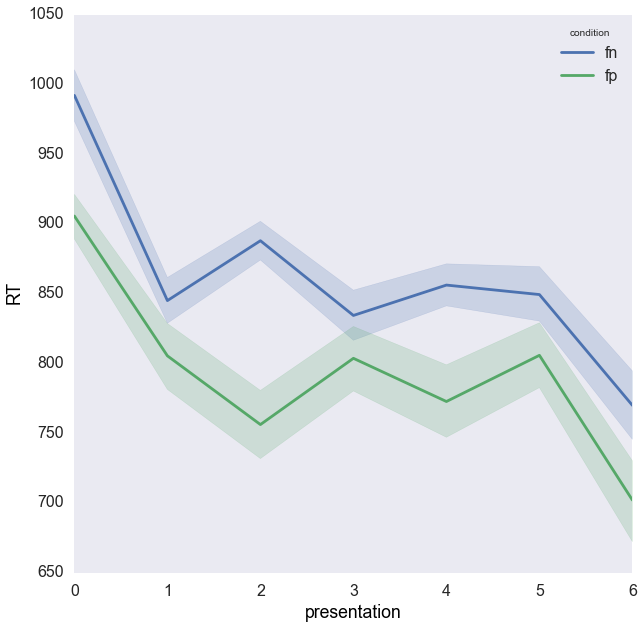

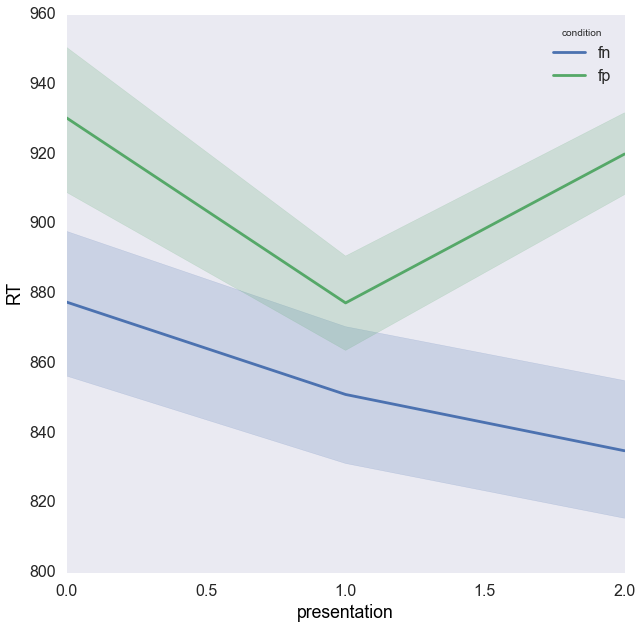

In [63]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_switch_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

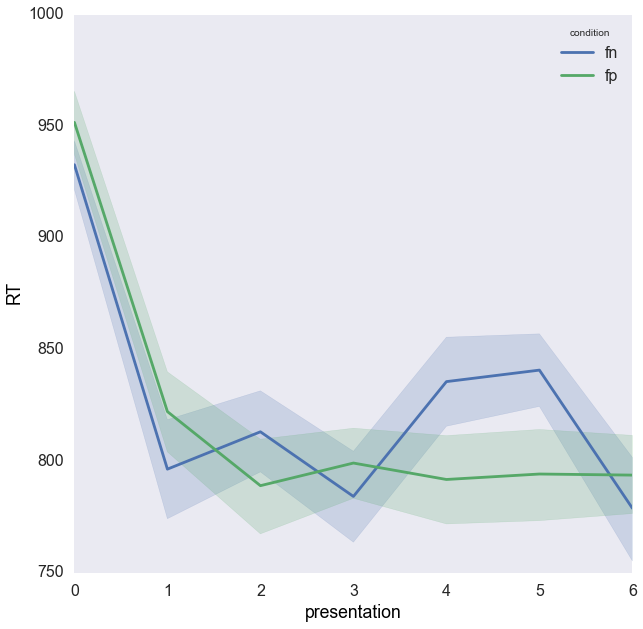

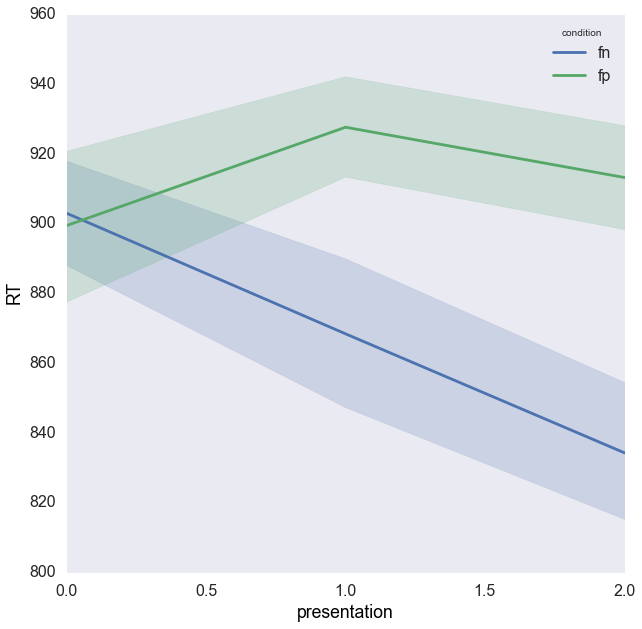

In [64]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_switch_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')


In [114]:
#ser
f = '914_3'
fb_iti = np.array(full_data[f]['fb_iti_ser'].split(',')).astype('float')/1000.0
iti_dur_full = np.array(full_data[f]['iti_dur_full_ser'].split(',')).astype('float')/1000.0
iti_dur = np.array(full_data[f]['iti_dur_ser'].split(',')).astype('float')/1000.0
im_time = np.array(full_data[f]['im_time_ser'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_ser'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_ser'].split(',')).astype('float')
tar_time = np.array(full_data[f]['tar_time_ser'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_ser'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_ser'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_ser'].split(',')))

print rew
print order
itis = np.where(np.array(order) < 9)
tmp_rew = rew[itis]
rew_trials = np.where(tmp_rew == 1)
print im_time[rew_trials]
print tar_time
print tar_time - im_time[rew_trials]
print '/n'


predicted_im_time = []
predicted_iti_time = []
predicted_fb_time = []
start = im_time[0]
predicted_im_time.append(start)
im_duration = 1.5
iti_duration = .5
fb_duration = 1

for n in range(0,len(order)-1):
    if order[n] == 1 or order[n] == 4:
        next_im_time = predicted_im_time[-1] + im_duration + iti_dur_full[n]
        predicted_im_time.append(next_im_time)
    
    if order[n+1] == 10 and rew[n] == 0:
        predicted_iti_time.append(predicted_im_time[-1] + iti_dur[0] + im_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[1:]
        predicted_im_time.append(next_im_time)
        
    elif order[n+1] == 10 and rew[n] == 1:
        predicted_iti_time.append(predicted_fb_time[-1] + iti_dur[0] + fb_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[1:]
        predicted_im_time.append(next_im_time)
        
    elif rew[n + 1] == 1:
        predicted_fb_time.append(predicted_im_time[-1] + fb_iti[n+1] + im_duration)
   
        
print iti_time
print predicted_iti_time
print '\n'
print im_time
print predicted_im_time

print '\n'
print fb_time
print predicted_fb_time


[ 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[  1.   2.  10.   6.  10.   6.  10.   3.  10.   3.  10.   6.  10.   1.   2.
  10.   1.   2.  10.   3.  10.   3.  10.   4.   5.  10.   4.   5.  10.   1.
   2.  10.   6.  10.   3.  10.   6.  10.   4.   5.  10.   4.   5.  10.   4.
   5.  10.   3.  10.   1.   2.  10.   4.   5.  10.   4.   5.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   1.   2.  10.   1.   2.  10.   4.
   5.  10.   6.  10.   3.  10.   1.   2.  10.   3.  10.   6.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   6.  10.]
[  17.507427   34.515924   61.53915    75.049509  140.090904  159.097452
  172.104634

In [110]:
##sim
f = '914_2'
fb_iti= np.array(full_data[f]['fb_iti_sim'].split(',')).astype('float')/1000.0
iti_dur = np.array(full_data[f]['iti_dur_sim'].split(',')).astype('float')/1000.0
im_time = np.array(full_data[f]['im_time_sim'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_sim'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_sim'].split(',')).astype('float')
tar_time = np.array(full_data[f]['tar_time_sim'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_sim'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_sim'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_sim'].split(',')))

# rew_idx = []
# count = 0
# for i in range(0,len(rew),2):
#     if rew[i] == 1:
#         rew_idx.append(count)
#     count += 1
# print im_time[rew_idx]
# print tar_time
# print tar_time - im_time[rew_idx]

# # print '/n'
# print order
# print rew

print rew
print order
itis = np.where(np.array(order) < 9)
tmp_rew = rew[itis]
rew_trials = np.where(tmp_rew == 1)
print im_time[rew_trials]
print tar_time
print tar_time - im_time[rew_trials]
print '/n'

predicted_im_time = []
predicted_iti_time = []
predicted_fb_time = []
start = im_time[0]
predicted_im_time.append(start)
im_duration = 1.5
iti_duration = .5
fb_duration = 1

for n in range(0,len(order)-1):
    if order[n+1] == 10 and rew[n] == 0:

        predicted_iti_time.append(predicted_im_time[-1] + iti_dur[0] + im_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[2:]
        predicted_im_time.append(next_im_time)
        
    elif order[n+1] == 10 and rew[n] == 1:
        
        predicted_iti_time.append(predicted_fb_time[-1] + iti_dur[0] + fb_duration)
        next_im_time = predicted_iti_time[-1] + iti_duration + iti_dur[0]
        iti_dur = iti_dur[2:]
        predicted_im_time.append(next_im_time)
        
    elif rew[n + 1] == 1:
        
        predicted_fb_time.append(predicted_im_time[-1] + fb_iti[n+1] + im_duration)
   
        
print iti_time
print predicted_iti_time
print '\n'
print im_time
print predicted_im_time
print '\n'
print fb_time
print predicted_fb_time


[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.]
[  1.  10.   4.  10.   1.  10.   4.  10.   4.  10.   1.  10.   3.  10.   3.
  10.   1.  10.   2.  10.   1.  10.   4.  10.   1.  10.   3.  10.   4.  10.
   4.  10.   2.  10.   1.  10.   1.  10.   3.  10.   2.  10.   3.  10.   2.
  10.   3.  10.   4.  10.   1.  10.   3.  10.   2.  10.   2.  10.   3.  10.
   2.  10.   4.  10.   2.  10.   4.  10.   3.  10.   2.  10.   2.  10.   1.
  10.   4.  10.   3.  10.]
[  21.010777   38.01647    50.02       63.02365    79.028713   98.033874
  107.037377  118.04017   133.04611   146.049852  158.053275  183.075518
  227.075475  238.077865  249.080809  260.082366  291.085948  308.090198
  332.096022  357.102459]
[  21.611191   38.6156

In [88]:
def get_itis(all_itis,order,rew,cond_code, rew_code):
    cond = np.where([order == cond_code])[1]
    rewarded = np.where(rew[cond]== rew_code)
    indices = cond[rewarded]
    itis = all_itis[indices]
    return itis
    

In [103]:
f = '114_2'
im_time = np.array(full_data[f]['im_time_sim'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_sim'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_sim'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_sim'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_sim'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_sim'].split(',')))
print im_time
print order
print rew

#add iti times to im_time
im_time = np.concatenate((iti_time,im_time),axis=0)
im_time = np.sort(im_time)

#SIM AB+,B-,AC-,C+
#switch: AB-,B+,AC-,C+
print get_itis(im_time,order,rew,1, 1)

[  12.006573   17.912915   25.778636   37.537239   43.399664   56.161274
   66.920804   78.674532   85.540948   98.300686  103.165081  114.930374
  130.68594   139.443511  146.304994  161.068644  170.830943  179.590808
  185.450532  202.207536  206.070841  209.934046  214.799292  221.661792
  226.525923  239.280192  250.044527  263.799191  271.561359  278.418796
  285.282013  290.147176  303.905702  311.76335   322.521266  327.385272
  331.250189  343.005358  346.867175  354.726005]
[  1.  10.   4.  10.   1.  10.   4.  10.   4.  10.   1.  10.   3.  10.   3.
  10.   1.  10.   2.  10.   1.  10.   4.  10.   1.  10.   3.  10.   4.  10.
   4.  10.   2.  10.   1.  10.   1.  10.   3.  10.   2.  10.   3.  10.   2.
  10.   3.  10.   4.  10.   1.  10.   3.  10.   2.  10.   2.  10.   3.  10.
   2.  10.   4.  10.   2.  10.   4.  10.   3.  10.   2.  10.   2.  10.   1.
  10.   4.  10.   3.  10.]
[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  1.  0.

In [15]:
#ser
f = '914_3'
fb_iti = np.array(full_data[f]['fb_iti_ser'].split(',')).astype('float')/1000.0
iti_dur_full = np.array(full_data[f]['iti_dur_full_ser'].split(',')).astype('float')/1000.0
iti_dur = np.array(full_data[f]['iti_dur_ser'].split(',')).astype('float')/1000.0
im_time = np.array(full_data[f]['im_time_ser'].split(',')).astype('float')
fb_time = np.array(full_data[f]['fb_time_ser'].split(',')).astype('float')
iti_time = np.array(full_data[f]['iti_time_ser'].split(',')).astype('float')
tar_time = np.array(full_data[f]['tar_time_ser'].split(',')).astype('float')
cond = np.array( map(float, full_data[f]['cond_ser'].split(',') ))
rew =  np.array( map(float, full_data[f]['rew_ser'].split(',') ))
order = np.array( map(float, full_data[f]['trial_order_ser'].split(',')))
print order

[  1.   2.  10.   6.  10.   6.  10.   3.  10.   3.  10.   6.  10.   1.   2.
  10.   1.   2.  10.   3.  10.   3.  10.   4.   5.  10.   4.   5.  10.   1.
   2.  10.   6.  10.   3.  10.   6.  10.   4.   5.  10.   4.   5.  10.   4.
   5.  10.   3.  10.   1.   2.  10.   4.   5.  10.   4.   5.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   1.   2.  10.   1.   2.  10.   4.
   5.  10.   6.  10.   3.  10.   1.   2.  10.   3.  10.   6.  10.   6.  10.
   3.  10.   4.   5.  10.   1.   2.  10.   6.  10.]
